Same task as the first notebook but continuous actions

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import highway_env
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import MultivariateNormal
from collections import deque
import random

from configs.config_continuous import config_dict as config_dict_continuous

In [16]:
# Create and configure environment
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config_dict_continuous)
state, _ = env.reset()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Check environment details
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Observation space: Box(-inf, inf, (5, 5), float32)
Action space: Box(-1.0, 1.0, (1,), float32)


In [20]:
env.unwrapped.config["high_speed_reward"]

0.4

In [4]:
test_actions = np.array([[0, 0.5] for _ in range(10)]).reshape(-1, 2)  # 10 actions of [-1, 0] each
# Test the environment with random actions
state, _ = env.reset()
for action in test_actions:
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
state, _ = env.reset()


In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, action_std_init=0.6):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, action_dim)
        self.fc_std = nn.Linear(128, action_dim)
        
        self.action_dim = action_dim
        self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
        
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        action_mean = torch.tanh(self.fc_mean(x))  # Bound mean between -1 and 1
    
        MIN_STD = 1e-3
        action_std = torch.sigmoid(self.fc_std(x)) + MIN_STD  # Ensure std is never too small
        
        cov_mat = torch.diag_embed(action_std ** 2).to(device)  # Use variance
        return action_mean, cov_mat
        
    def act(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).to(device)
        action_mean, cov_mat = self.forward(state)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach().cpu().numpy(), action_logprob.detach()
    
    def evaluate(self, state, action):
        action_mean, cov_mat = self.forward(state)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        return action_logprobs, dist_entropy

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_out = nn.Linear(128, 1)
        
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        value = self.fc_out(x)
        return value

class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class PPO:
    def __init__(self, state_dim, action_dim, lr_actor=0.0003, lr_critic=0.001, gamma=0.99, K_epochs=80, eps_clip=0.2):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()
        
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.value_net = ValueNetwork(state_dim).to(device)
        self.old_policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.old_policy.load_state_dict(self.policy.state_dict())
        
        self.optimizer_actor = optim.Adam(self.policy.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.value_net.parameters(), lr=lr_critic)
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state):
        with torch.no_grad():
            action, action_logprob = self.old_policy.act(state)
            
        self.buffer.states.append(torch.FloatTensor(state).to(device))
        self.buffer.actions.append(torch.FloatTensor(action).to(device))
        self.buffer.logprobs.append(action_logprob)
        
        return action
    
    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        
        # Convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Evaluating old actions and values
            logprobs, dist_entropy = self.policy.evaluate(old_states, old_actions)
            state_values = self.value_net(old_states)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss_actor = -torch.min(surr1, surr2).mean() + 0.01 * dist_entropy.mean()
            
            # Value loss
            loss_critic = self.MseLoss(state_values, rewards)
            
            # Take gradient step
            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            loss_actor.backward()
            loss_critic.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
            
        # Copy new weights into old policy
        self.old_policy.load_state_dict(self.policy.state_dict())
        
        # clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path):
        torch.save(self.old_policy.state_dict(), checkpoint_path)
    
    def load(self, checkpoint_path):
        self.old_policy.load_state_dict(torch.load(checkpoint_path, map_location=device))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=device))

In [6]:
# Training parameters
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]
max_episodes = 500
max_timesteps = 200
update_timestep = 100  # update policy every n timesteps

# Initialize PPO agent
# ppo_agent = PPO(state_dim, action_dim, lr_actor=0.0003, lr_critic=0.001, gamma=0.99, K_epochs=80, eps_clip=0.2)
ppo_agent = PPO(
    state_dim, 
    action_dim, 
    lr_actor=0.003, 
    lr_critic=0.01, 
    gamma=0.95,        # More focus on short-term rewards
    K_epochs=20,       # Less overfitting to each batch
    eps_clip=0.3       # Allow greater policy updates
)


In [7]:
# Logging variables
ep_rewards = []
epsilon_values = []
episode_lengths = []
avg_rewards = []
time_step = 0

# Training loop
for episode in range(1, max_episodes+1):
    state, _ = env.reset()
    state = state.flatten()
    
    episode_reward = 0
    
    for t in range(1, max_timesteps+1):
        time_step += 1
        
        # Select action with policy
        action = ppo_agent.select_action(state)
        
        # Take action in environment
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # print("on_road_reward",  info["rewards"]["on_road_reward"], end = "\r")
        if info["rewards"]["on_road_reward"] == 0:
            # reward = -1
            done = True
        
        # Store in buffer
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        state = next_state.flatten()
        episode_reward += reward
        
        # Update if it's time
        if time_step % update_timestep == 0:
            ppo_agent.update()
        
        if done:
            break
    
    ep_rewards.append(episode_reward)
    episode_lengths.append(t)
    epsilon_values.append(ppo_agent.policy.action_var.cpu().numpy())
    avg_reward = np.mean(ep_rewards[-10:])
    avg_rewards.append(avg_reward)
    
    print(f"Episode: {episode:4d}, Reward: {episode_reward:7.2f}, Avg Reward (last 100): {avg_reward:7.2f}", end="\r")
    
    # Early stopping if we've solved the environment
    if avg_reward >= 30:  # You may need to adjust this threshold
        print(f"Solved at episode {episode} with average reward {avg_reward:.2f}!")
        break

ValueError: The right-most size of value must match event_shape: torch.Size([100]) vs torch.Size([1]).

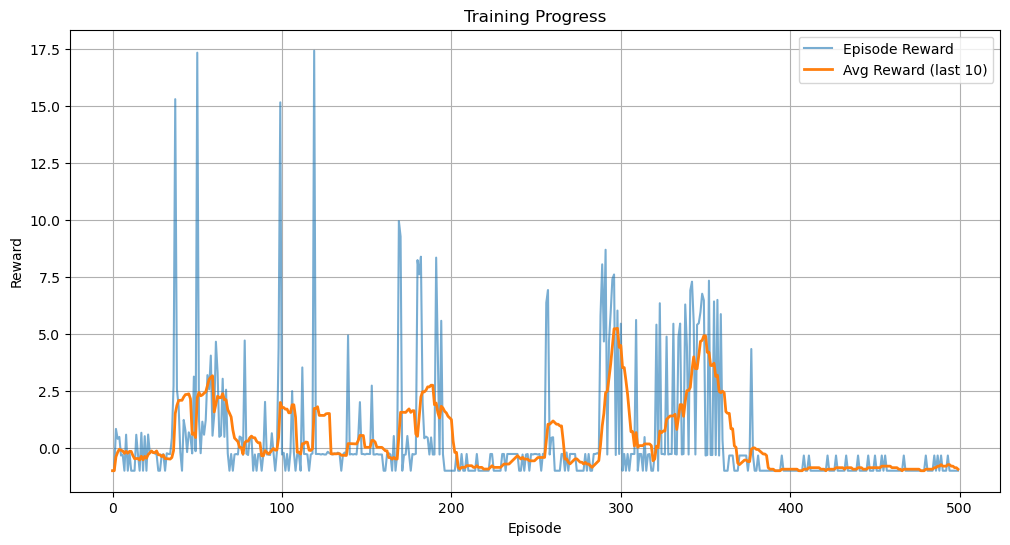

In [9]:
# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(ep_rewards, label='Episode Reward', alpha=0.6)
plt.plot(avg_rewards, label='Avg Reward (last 10)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.legend()
plt.grid()
plt.show()

# Save the trained model
torch.save(ppo_agent.policy.state_dict(), "models/task_2_ppo_highway.pth")

In [10]:
ppo_agent.load("models/task_2_ppo_highway.pth")

C:\Users\tedma\AppData\Local\Temp\ipykernel_3812\3687251893.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.old_policy.load_state_dict(torch.load(checkpoint_path,

In [11]:
# Test the trained agent
def test_agent(env, agent, num_episodes=5):
    n_success = 0
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = state.flatten()
        episode_reward = 0
        
        while True:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            state = next_state.flatten()
            episode_reward += reward
            
            if done:
                break
        
        if info["crashed"] == 0:
            n_success += 1
        
        print(f"Episode {episode + 1}: Reward: {episode_reward:.2f}, Success: {info['crashed'] == 0}")
    success_rate = n_success / num_episodes * 100
    print(f"Success Rate: {success_rate:.2f}%")
test_agent(env, ppo_agent, num_episodes=5)

Episode 1: Reward: 0.73, Success: True
Episode 2: Reward: 3.78, Success: True
Episode 3: Reward: 2.07, Success: True
Episode 4: Reward: 4.73, Success: True
Episode 5: Reward: 0.71, Success: True
Success Rate: 100.00%


In [12]:

while True:
  state, _ = env.reset()
  state = state.flatten()
  episode_reward = 0
  
  while True:
      action = ppo_agent.select_action(state)
      next_state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated or (not info["rewards"]["on_road_reward"])

      if done:
         break
      
      state = next_state.flatten()
      env.render()

AttributeError: 'NoneType' object has no attribute 'get_image'